In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [8]:
def prune(a, ref):
    b = np.concatenate(([False], np.diff(a) < ref))
    c = np.concatenate(([False], np.diff(b.astype(int)) > 0))
    d = a[~c]
    if any(np.diff(a) < ref):
        d = prune(d, ref)
    return d


def generate_stim_times(stim_rate, stim_isi_min, stop_time):
    stim_times = np.sort(np.random.uniform(
        0, stop_time, stim_rate * stop_time))
    return prune(stim_times, stim_isi_min)


def generate_neurons(stim_times, make_post=False, **p):
    n_stim = len(stim_times)
    idxs = np.random.permutation(np.arange(n_stim).astype(int))
    n_stim_spikes = int(n_stim * p['stim_hit_chance'])
    idxs_stim_spikes = idxs[:n_stim_spikes]

    spikes = np.sort(np.concatenate([
        stim_times[idxs_stim_spikes] + p['stim_latency'],
        np.random.uniform(0, p['stop_time'], p['pre_rate'] * p['stop_time'])
    ]))
    pre_spikes = prune(spikes, p['refractory'])
    n_pre_spikes = len(pre_spikes)
    if make_post:
        n_post_spikes = int(n_pre_spikes * p['pre_hit_chance'])
        idxs_post_spikes = np.random.permutation(np.arange(n_pre_spikes).astype(int))[:n_post_spikes]

        post_spikes = np.sort(np.concatenate([
            pre_spikes[idxs_post_spikes] + p['latency'],
            np.random.uniform(0, p['stop_time'], int(p['post_rate'] * p['stop_time']))
        ]))
        post_spikes = prune(post_spikes, p['refractory'])
    
        return pre_spikes, post_spikes
    else:
        return pre_spikes
    

def histogram(val, bins):
    '''
    Assuming:
        val, bins are sorted
        bins increase monotonically and uniformly
        all(bins[0] <= v <= bins[-1] for v in val)
    '''
    result = np.zeros(len(bins) - 1).astype(int)
    search = np.searchsorted(bins, val, side='right')
    cnt = np.bincount(search)[1:len(result)]
    result[:len(cnt)] = cnt
    return result
    

def create_design_matrix(times, bins, n):
    result = [histogram(times, bins=bins)]
    for i in range(1, n):
        result.append(
            np.concatenate([
                np.zeros(i),
                result[0][:-i]
            ])
        )
    return np.array(result)


def OLS(X, y):
    dot, inv = np.dot, np.linalg.inv
    return dot(dot(inv(dot(X.T, X)), X.T), y)


def IV(pre, post, stim_times, stop_time, stim_duration, 
       sigma, refractory, latency, stim_latency, plot=False, verbose=False):

    bins = np.arange(0, stop_time + sigma, sigma)
    ref_steps = int(refractory / sigma)
    if verbose:
        print('Effective refractory time',ref_steps * sigma * 1000, 'ms')
    
    pre_binary_design = create_design_matrix(
        pre, bins, ref_steps)
    
    stim_steps = int(stim_duration / sigma)
    
    if verbose:
        print('Effective stimulation time', stim_steps * sigma * 1000, 'ms')
    
    S = create_design_matrix(
        stim_times, bins, stim_steps).sum(axis=0).astype(bool)
    
    X = pre_binary_design[0]
    Z = pre_binary_design[1:]    
    Z = Z.T
    Z = np.hstack((np.ones((Z.shape[0], 1)), Z))
    
    X = X[S]
    Z = Z[S]
    
    Y = histogram(post, bins=bins)
    
    W = OLS(Z, X)
    X_fittedvalues = np.dot(W, Z.T)
    
    Y = Y[S]
#     X_fittedvalues = X_fittedvalues[S]
        
    XX = np.array([np.ones(X_fittedvalues.shape[0]), X_fittedvalues])

    _, beta_IV = OLS(XX.T, Y.astype(float))
    
    return beta_IV

# Increasing hit chance A -> C

In [9]:
results = []
for h in np.arange(.1, 1.1, .1):
    stim_params = {
        'stop_time': 2000, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 50e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 6e-3, # post response delay
        'pre_hit_chance': h, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
        'stim_latency': 5e-4, # latency from stim to pre response
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'stim_duration': 8e-3, # size of chunk to clip out after (latency corrected) stim
        'sigma': 1e-3, # resolution for histograms
        'stop_time': stim_params['stop_time'],
        'refractory': neuron_params['refractory'],
        'latency': neuron_params['latency'],
        'stim_latency': neuron_params['stim_latency'],
    }
    
    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        pre=A_spikes, post=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        pre=B_spikes, post=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    }
    results.append({**stim_params, **neuron_params, **iv_params, **res})
    
results = pd.DataFrame(results)
results

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,latency,post_rate,pre_hit_chance,pre_rate,refractory,sigma,stim_duration,stim_hit_chance,stim_isi_min,stim_latency,stim_rate,stop_time
0,14.1315,14.1425,1.2560,6.2560,12.0100,0.087417,0.085781,0.006,5,0.1,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000
1,14.1435,14.1685,2.6120,7.6120,12.0410,0.195954,0.186215,0.006,5,0.2,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000
2,14.1390,14.1715,3.9855,8.9855,12.0345,0.284783,0.276885,0.006,5,0.3,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000
3,14.1480,14.1655,5.3375,10.3375,12.0080,0.371088,0.361499,0.006,5,0.4,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000
4,14.1460,14.1685,6.7000,11.7000,12.0375,0.474376,0.459117,0.006,5,0.5,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000
5,14.1140,14.0660,8.0375,13.0375,11.9670,0.561068,0.550857,0.006,5,0.6,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000
6,14.1480,14.1440,9.4140,14.4140,12.0060,0.659813,0.642355,0.006,5,0.7,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000
7,14.1400,14.1395,10.7855,15.7855,11.9980,0.751772,0.728470,0.006,5,0.8,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000
8,14.0815,14.0945,12.0695,17.0695,11.9630,0.844558,0.816041,0.006,5,0.9,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000
9,14.1465,14.1320,13.5170,18.5170,11.9815,0.946868,0.915994,0.006,5,1.0,5,0.004,0.001,0.008,0.8,0.05,0.0005,30,2000


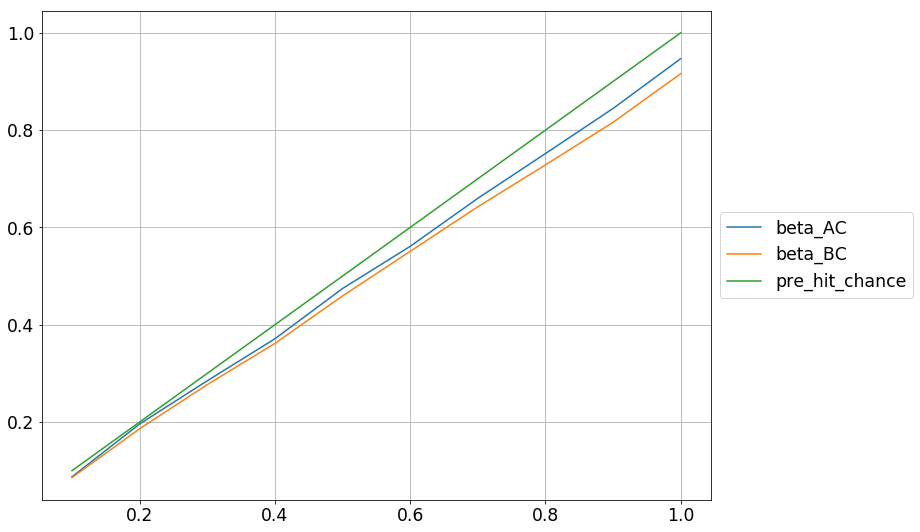

In [10]:
keys = [
#     'A_rate',
#     'B_rate',
#     'C_rate',
#     'S_rate',
    'beta_AC',
    'beta_BC',
    'pre_hit_chance'
]

cmap = cm.get_cmap('tab10')
cnt = 0
for key in keys:
    plt.plot(results['pre_hit_chance'], results[key], label=key, color=cmap(cnt))
    cnt += 1
plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Increasing stop time

In [6]:
results = []
for h in np.arange(100, 2010, 10):
    stim_params = {
        'stop_time': h, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 50e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 6e-3, # post response delay
        'pre_hit_chance': .5, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
        'stim_latency': 5e-4, # latency from stim to pre response
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'stim_duration': 1e-3, # size of chunk to clip out after (latency corrected) stim
        'sigma': 1e-3, # resolution for histograms
        'stop_time': stim_params['stop_time'],
        'refractory': neuron_params['refractory'],
        'latency': neuron_params['latency'],
        'stim_latency': neuron_params['stim_latency'],
    }
    
    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        pre=A_spikes, post=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        pre=B_spikes, post=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    }
    results.append({**stim_params, **neuron_params, **iv_params, **res})
    
results = pd.DataFrame(results)
results.head()

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,latency,post_rate,pre_hit_chance,pre_rate,refractory,sigma,stim_duration,stim_hit_chance,stim_isi_min,stim_latency,stim_rate,stop_time
0,14.100000,14.180000,6.670000,11.670000,12.060000,0.497349,-6.881431e-14,0.006,5,0.5,5,0.004,0.001,0.001,0.8,0.05,0.0005,30,100
1,14.236364,14.290909,6.727273,11.727273,12.172727,0.482330,-2.671522e-01,0.006,5,0.5,5,0.004,0.001,0.001,0.8,0.05,0.0005,30,110
2,14.250000,14.291667,6.833333,11.833333,12.216667,0.483786,1.958634e-01,0.006,5,0.5,5,0.004,0.001,0.001,0.8,0.05,0.0005,30,120
3,14.061538,14.123077,6.692308,11.692308,11.969231,0.495466,2.093702e-01,0.006,5,0.5,5,0.004,0.001,0.001,0.8,0.05,0.0005,30,130
4,14.085714,14.092857,6.678571,11.678571,11.942857,0.487102,-8.952959e-02,0.006,5,0.5,5,0.004,0.001,0.001,0.8,0.05,0.0005,30,140


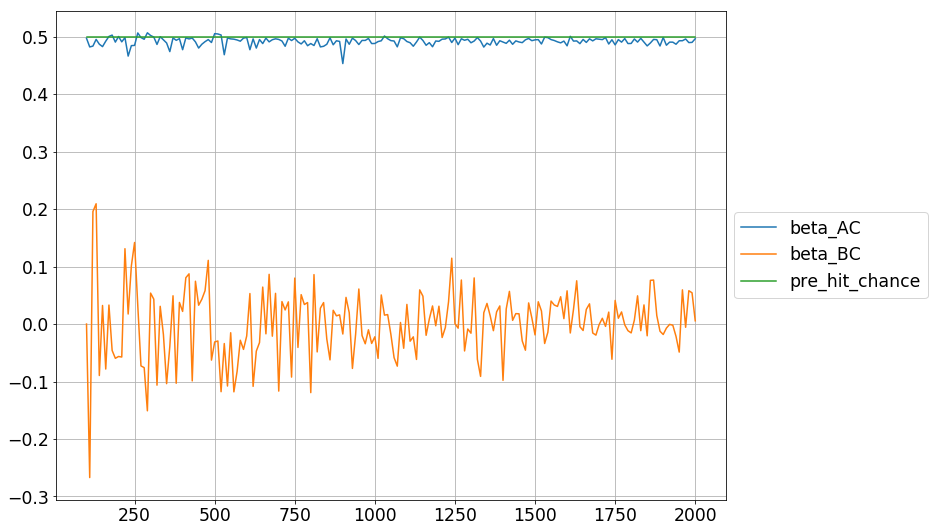

In [7]:
keys = [
#     'A_rate',
#     'B_rate',
#     'C_rate',
#     'S_rate',
    'beta_AC',
    'beta_BC',
    'pre_hit_chance'
]

cmap = cm.get_cmap('tab10')
cnt = 0
for key in keys:
    plt.plot(results['stop_time'], results[key], label=key, color=cmap(cnt))
    cnt += 1
plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))